# マルチモーダル記事質問応答アシスタント

### インポート

In [ ]:
pip install ollama

In [20]:
import json
from functions import *
from transformers import CLIPProcessor, CLIPModel
from torch import load, matmul, argsort
from torch.nn.functional import softmax

from IPython.display import Image

import ollama

### データを読み込む

In [21]:
# 記事内容を読み込む
text_content_list = load_from_json('data/text_content.json')
image_content_list = load_from_json('data/image_content.json')

# 埋め込みを読み込む
text_embeddings = load('data/text_embeddings.pt', weights_only=True)
image_embeddings = load('data/image_embeddings.pt', weights_only=True)

In [22]:
print(text_embeddings.shape)
print(image_embeddings.shape)

torch.Size([38, 512])
torch.Size([11, 512])


In [23]:
text_content_list[37]

{'article_title': 'Untitled',
 'section': 'まとめ',
 'text': 'また、LIGでは生成AIコンサルティング事業をおこなっています。ぜひお気軽にご相談ください。'}

### クエリー

In [24]:
# クエリー
query = "RAGのアーキテクチャとは？"
# クエリを埋め込みベクトルに変換
query_embed = embed_text(query)

In [25]:
query_embed.shape

torch.Size([1, 512])

### マルチモーダル検索

In [26]:
k = 5
threshold = 0.1

# 記事に対するマルチモーダル検索
text_similarities = matmul(query_embed, text_embeddings.T)
image_similarities = matmul(query_embed, image_embeddings.T)

# ソフトマックスで類似度を再スケーリング
temp=0.25
text_scores = softmax(text_similarities/temp, dim=1)
image_scores = softmax(image_similarities/temp, dim=1)

# 上位k件のフィルタリングされたテキスト結果を返す
isorted_scores = argsort(text_scores, descending=True)[0]
sorted_scores = text_scores[0][isorted_scores]

itop_k_filtered = [idx.item() for idx, score in zip(isorted_scores, sorted_scores) if score.item() >= threshold][:k]
top_k = [text_content_list[i] for i in itop_k_filtered]

top_k

[{'article_title': 'Untitled',
  'section': 'RAGのアーキテクチャ',
  'text': 'ドキュメントの読み込み：最初に、文書やデータソースをロードします。チャンクへの分割： 文書を扱いやすいサイズに分割します。エンベディングの生成： 分割した各チャンクをエンベディングを使ってベクトル表現に変換します。ベクターデータベースへの保存： これらのベクトルをベクターデータベースに保存し、効率的に検索できるようにします。ユーザーとのインタラクション： ユーザーからのクエリや入力を受け取り、エンベディングに変換します。ベクターデータベースでのセマンティック検索： ユーザーのクエリに基づいてベクターデータベースでセマンティック検索を行います。レスポンスの取得と処理： 関連するレスポンスを取得し、それを大規模言語モデル（LLM）で処理して回答を生成します。ユーザーへの回答の提供： LLMによって生成された最終的な回答をユーザーに提示します。'},
 {'article_title': 'Untitled',
  'section': 'RAGのアーキテクチャ',
  'text': '画像出典：https://newsletter.nocode.ai/p/guide-retrieval-augmented-generationこちらの画像で説明されているように、RAGのアーキテクチャは通常、以下の8つのステップを含みます。'}]

#### text and image search

In [27]:
text_results, text_scores = similarity_search(query_embed, text_embeddings, text_content_list, k=15, threshold=0.01, temperature=0.25)
image_results, image_scores = similarity_search(query_embed, image_embeddings, image_content_list, k=5, threshold=0.25, temperature=0.5)

In [28]:
i=1
for text in text_results:
    if text_results:
        print(i, "-", text['text'])
        i=i+1

1 - ドキュメントの読み込み：最初に、文書やデータソースをロードします。チャンクへの分割： 文書を扱いやすいサイズに分割します。エンベディングの生成： 分割した各チャンクをエンベディングを使ってベクトル表現に変換します。ベクターデータベースへの保存： これらのベクトルをベクターデータベースに保存し、効率的に検索できるようにします。ユーザーとのインタラクション： ユーザーからのクエリや入力を受け取り、エンベディングに変換します。ベクターデータベースでのセマンティック検索： ユーザーのクエリに基づいてベクターデータベースでセマンティック検索を行います。レスポンスの取得と処理： 関連するレスポンスを取得し、それを大規模言語モデル（LLM）で処理して回答を生成します。ユーザーへの回答の提供： LLMによって生成された最終的な回答をユーザーに提示します。
2 - 画像出典：https://newsletter.nocode.ai/p/guide-retrieval-augmented-generationこちらの画像で説明されているように、RAGのアーキテクチャは通常、以下の8つのステップを含みます。
3 - そもそも「RAG」とは？RAGのアーキテクチャさっそく実験してみた前提LangFlowのインストール方法構築のヒントLangflowから作成したフローをWebウィジェット(HTML)に変換してみるまとめ
4 - 以前にPython言語でLangchain、StreamlitとChatGPTモデルを活用してRAGを作成しました。以下の記事で解説していますので、ぜひご覧ください。


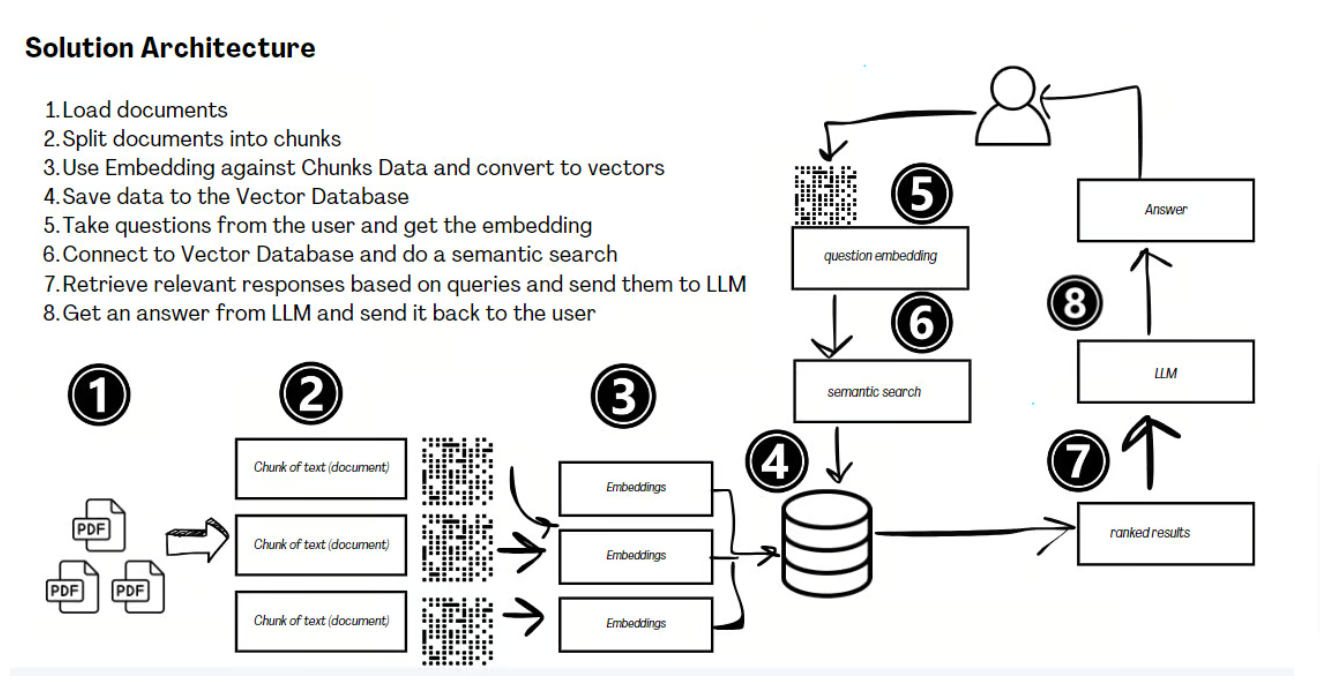

In [29]:
for image in image_results:
    display(Image(filename=image['image_path']))

### プロンプト設計

#### コンテキストを整形

In [30]:
text_context = ""
for text in text_results:
    if text_results:
        text_context = text_context + "**記事タイトル:** " + text['article_title'] + "\n"
        text_context = text_context + "**セクション:** " + text['section'] + "\n"
        text_context = text_context + "**スニペット:** " + text['text'] + "\n\n"

In [31]:
image_context = ""
for image in image_results:
    if image_results:
        image_context = image_context + "**記事タイトル:** " + image['article_title'] + "\n"
        image_context = image_context + "**セクション:** " + image['section'] + "\n"
        image_context = image_context + "**画像パス:** " + image['image_path'] + "\n"
        image_context = image_context + "**画像キャプション:** " + image['caption'] + "\n\n"

#### プロンプトの構築

In [32]:
# プロンプトテンプレートを作成
prompt = f"""以下の質問「{query}」と、関連するスニペットが提供されています。

{text_context}
{image_context}

提供されたスニペットから得られる情報を基に、簡潔で正確な回答を作成してください。

"""

In [33]:
print(prompt)

以下の質問「RAGのアーキテクチャとは？」と、関連するスニペットが提供されています。

**記事タイトル:** Untitled
**セクション:** RAGのアーキテクチャ
**スニペット:** ドキュメントの読み込み：最初に、文書やデータソースをロードします。チャンクへの分割： 文書を扱いやすいサイズに分割します。エンベディングの生成： 分割した各チャンクをエンベディングを使ってベクトル表現に変換します。ベクターデータベースへの保存： これらのベクトルをベクターデータベースに保存し、効率的に検索できるようにします。ユーザーとのインタラクション： ユーザーからのクエリや入力を受け取り、エンベディングに変換します。ベクターデータベースでのセマンティック検索： ユーザーのクエリに基づいてベクターデータベースでセマンティック検索を行います。レスポンスの取得と処理： 関連するレスポンスを取得し、それを大規模言語モデル（LLM）で処理して回答を生成します。ユーザーへの回答の提供： LLMによって生成された最終的な回答をユーザーに提示します。

**記事タイトル:** Untitled
**セクション:** RAGのアーキテクチャ
**スニペット:** 画像出典：https://newsletter.nocode.ai/p/guide-retrieval-augmented-generationこちらの画像で説明されているように、RAGのアーキテクチャは通常、以下の8つのステップを含みます。

**記事タイトル:** Untitled
**セクション:** Main
**スニペット:** そもそも「RAG」とは？RAGのアーキテクチャさっそく実験してみた前提LangFlowのインストール方法構築のヒントLangflowから作成したフローをWebウィジェット(HTML)に変換してみるまとめ

**記事タイトル:** Untitled
**セクション:** RAGのアーキテクチャ
**スニペット:** 以前にPython言語でLangchain、StreamlitとChatGPTモデルを活用してRAGを作成しました。以下の記事で解説していますので、ぜひご覧ください。


**記事タイトル:** Untitled
**セクション:** Langflowから作成したフローをWebウィ

### プロンプトLLM

In [34]:
ollama.pull('llama3.2-vision')

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [36]:
response = ollama.chat(
    model='llama3.2-vision',
    messages=[{
        'role': 'user',
        'content': f"以下の指示に従って回答してください。日本語で返答してください: {prompt}",
        'images': [image["image_path"] for image in image_results]
    }]
)

print(response['message']['content'])

RAG (Retrieval-Augmented Generation) アーキテクチャとは、以下の8つのステップを含むデータ処理アプローチです。



1.  ドキュメントの読み込み：最初に、文書やデータソースをロードします。
2.  チャンクへの分割： 文書を扱いやすいサイズに分割します。
3.  エンベディングの生成： 分割した各チャンクをエンベディングを使ってベクトル表現に変換します。
4.  ベクターデータベースへの保存： これらのベクトルをベクターデータベースに保存し、効率的に検索できるようにします。
5.  ユーザーとのインタラクション： ユーザーからのクエリや入力を受け取り、エンベディングに変換します。
6.  ベクターデータベースでのセマンティック検索： ユーザーのクエリに基づいてベクターデータベースでセマンティック検索を行います。
7.  レスポンスの取得と処理： 関連するレスポンスを取得し、それを大規模言語モデル（LLM）で処理して回答を生成します。
8.  ユーザーへの回答の提供： LLMによって生成された最終的な回答をユーザーに提示します。



RAGは、質問に基づいて関連する情報を検索し、それらの情報を大規模言語モデル（LLM）で処理して回答を生成することを目的としたアプローチです。
